In [1]:
%load_ext autoreload
%matplotlib inline

# Anomaly Detection Evaluation

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.features, plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

## Sliding window size

In [3]:
# 10min, B1
B1_10 = feature_extraction.load_features_from_file("features_b1_sw-10min*")
B1_10_s = preprocessing.scale_robust(B1_10)

# 30min, B1
B1_30 = feature_extraction.load_features_from_file("features_b1_sw-30min*")
B1_30_s = preprocessing.scale_robust(B1_30)

# 30min, B2
B2_30 = feature_extraction.load_features_from_file("features_b2_sw-30min*")
B2_30_s = preprocessing.scale_robust(B2_30)

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-10min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-10min_2018-03-13.csv' instead.
Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.
Loading file '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min_2018-02-26.csv' instead.


In [4]:
display(B1_10.describe(), B1_30.describe(), B2_30.describe())

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
count                46090.000000                46090.000000   
mean                     4.198113                    4.319727   
std                     10.024738                   10.622216   
min                    -98.760600                    0.000000   
25%                      2.047400                    2.080300   
50%                      2.053500                    2.085100   
75%                      4.440000                    4.484500   
max                    139.318100                  139.371000   

       MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
count              46090.000000              46090.000000   
mean                3685.279259               3685.223454   
std                 2893.033278               2892.939678   
min                  400.200000                400.000000   
25%                  450.000000                450.000000   
50%                 3565.920000               3566.000000   
75%                 6499.440000               6499.000000   
max                 7864.200000               7864.000000   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.DB1:T_FALLTIME  \
count                  46090.000000                  46090.000000   
mean                       1.389165                      1.349925   
std                        1.918227                      5.137006   
min                     -125.379000                   -125.578800   
25%                        1.390000                      1.381300   
50%                        1.393700                      1.384700   
75%                        1.400500                      1.391700   
max                      125.457900                    125.626800   

       MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
count                  46090.000000              46090.000000   
mean                      53.097154               3685.223454   
std                        6.555854               2892.939678   
min                      -13.831000                400.000000   
25%                       52.286000                450.000000   
50%                       52.288000               3566.000000   
75%                       52.291000               6499.000000   
max                       62.789000               7864.000000   

       MKI.UA23.IPOC.CB1:I_STRENGTH  MKI.UA23.IPOC.BB1:T_RISETIME  \
count                  46090.000000                  46090.000000   
mean                       4.508697                      0.657376   
std                        0.640664                      0.183260   
min                        1.403700                    -13.460900   
25%                        4.554300                      0.659700   
50%                        4.684400                      0.660200   
75%                        4.921000                      0.664800   
max                        5.039300                     13.039100   

                         ...                      \
count                    ...                       
mean                     ...                       
std                      ...                       
min                      ...                       
25%                      ...                       
50%                      ...                       
75%                      ...                       
max                      ...                       

       MKI.B5L2.B1:TEMP_TUBE_UP:SW_SUM_600_s  \
count                           46090.000000   
mean                            23443.544381   
std                              9319.531057   
min                             12420.000000   
25%                             15015.900000   
50%                             21420.250000   
75%                             30849.600000   
max                             50512.000000   

       MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_600_s  \
count                           46090.000000   
mean                            27377.89029

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
count                46090.000000                46090.000000   
mean                     4.198113                    4.319727   
std                     10.024738                   10.622216   
min                    -98.760600                    0.000000   
25%                      2.047400                    2.080300   
50%                      2.053500                    2.085100   
75%                      4.440000                    4.484500   
max                    139.318100                  139.371000   

       MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
count              46090.000000              46090.000000   
mean                3685.279259               3685.223454   
std                 2893.033278               2892.939678   
min                  400.200000                400.000000   
25%                  450.000000                450.000000   
50%                 3565.920000               3566.000000   
75%                 6499.440000               6499.000000   
max                 7864.200000               7864.000000   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.DB1:T_FALLTIME  \
count                  46090.000000                  46090.000000   
mean                       1.389165                      1.349925   
std                        1.918227                      5.137006   
min                     -125.379000                   -125.578800   
25%                        1.390000                      1.381300   
50%                        1.393700                      1.384700   
75%                        1.400500                      1.391700   
max                      125.457900                    125.626800   

       MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
count                  46090.000000              46090.000000   
mean                      53.097154               3685.223454   
std                        6.555854               2892.939678   
min                      -13.831000                400.000000   
25%                       52.286000                450.000000   
50%                       52.288000               3566.000000   
75%                       52.291000               6499.000000   
max                       62.789000               7864.000000   

       MKI.UA23.IPOC.CB1:I_STRENGTH  MKI.UA23.IPOC.BB1:T_RISETIME  \
count                  46090.000000                  46090.000000   
mean                       4.508697                      0.657376   
std                        0.640664                      0.183260   
min                        1.403700                    -13.460900   
25%                        4.554300                      0.659700   
50%                        4.684400                      0.660200   
75%                        4.921000                      0.664800   
max                        5.039300                     13.039100   

                          ...                      \
count                     ...                       
mean                      ...                       
std                       ...                       
min                       ...                       
25%                       ...                       
50%                       ...                       
75%                       ...                       
max                       ...                       

       MKI.B5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
count                            46090.000000   
mean                             69802.378831   
std                              27581.749008   
min                              37260.000000   
25%                              45221.850000   
50%                              64418.400000   
75%                              89284.850000   
max                             152057.000000   

       MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
count                            46090.000000   
mean                   

MKI.UA87.IPOC.BB2:I_STRENGTH  MKI.UA87.IPOC.DB2:E_KICK  \
count                  46812.000000              46812.000000   
mean                       4.680764               3492.409271   
std                        0.550494               2773.334648   
min                        1.909200                400.200000   
25%                        4.606500                450.000000   
50%                        4.819600               3319.200000   
75%                        5.029300               6499.400000   
max                        5.152500               8000.000000   

       MKI.UA87.IPOC.CB2:T_START_TH  MKI.UA87.IPOC.AB2:I_STRENGTH  \
count                  46812.000000                  46812.000000   
mean                      55.415762                      4.711285   
std                       10.989227                      0.553518   
min                      -13.723000                      1.915200   
25%                       52.296000                      4.639200   
50%                       52.297000                      4.849600   
75%                       52.299000                      5.062900   
max                       79.287000                      5.185700   

       MKI.UA87.IPOC.DB2:T_START_TH  MKI.UA87.IPOC.CB2:T_RISETIME  \
count                  46812.000000                  46812.000000   
mean                      55.405350                      0.652701   
std                       10.978175                      0.166108   
min                      -13.736000                    -13.194000   
25%                       52.283000                      0.655900   
50%                       52.285000                      0.656600   
75%                       52.287000                      0.661400   
max                       79.274000                     12.869400   

       MKI.UA87.IPOC.BB2:T_FALLTIME  MKI.UA87.IPOC.BB2:T_DELAY  \
count                  46812.000000               46812.000000   
mean                       1.394923                  56.775812   
std                        3.794821                   9.375754   
min                     -125.562200                  52.952200   
25%                        1.386500                  52.966300   
50%                        1.389600                  52.969400   
75%                        1.396400                  52.974600   
max                      125.624200                  79.959300   

       MKI.UA87.IPOC.BB2:T_START_TH  MKI.UA87.IPOC.AB2:T_DELAY  \
count                  46812.000000               46812.000000   
mean                      55.424345                  56.760092   
std                       11.008750                   9.394327   
min                      -13.902000                  11.583300   
25%                       52.308000                  52.951800   
50%                       52.310000                  52.956300   
75%                       52.313000                  52.975200   
max                       79.299000                 117.904600   

                      ...                  MKI.C5R8.B2:PRESSURE:SW_SUM_1800_s  \
count                 ...                                        4.681200e+04   
mean                  ...                                        1.677432e-07   
std                   ...                                        5.172257e-08   
min                   ...                                        8.499000e-08   
25%                   ...                                        1.285505e-07   
50%                   ...                                        1.568545e-07   
75%                   ...                                        1.951372e-07   
max                   ...                                        4.706740e-07   

       MKI.D5R8.B2:TEMP_MAGNET_DOWN:SW_SUM_1800_s  \
count                                46812.000000   
mean                                 59443.194638   
std                                  10151.426202   
min                                  43380.00

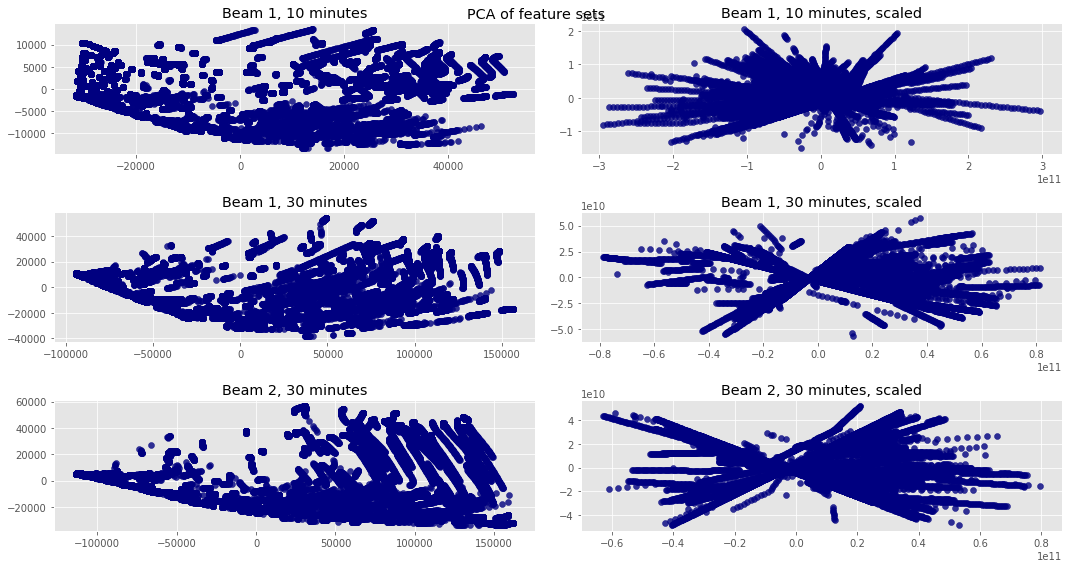

In [5]:
p = PCA.PCA(n_components=2)
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.suptitle("PCA of feature sets", fontsize="x-large")

plt.subplot(321)
B1_10_PCA = p.transform(B1_10)
plt.scatter(B1_10_PCA[:, 0], B1_10_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 10 minutes")

plt.subplot(322)
B1_10_s_PCA = p.transform(B1_10_s)
plt.scatter(B1_10_s_PCA[:, 0], B1_10_s_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 10 minutes, scaled")

plt.subplot(323)
B1_30_PCA = p.transform(B1_30)
plt.scatter(B1_30_PCA[:, 0], B1_30_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 30 minutes")

plt.subplot(324)
B1_30_s_PCA = p.transform(B1_30_s)
plt.scatter(B1_30_s_PCA[:, 0], B1_30_s_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 1, 30 minutes, scaled")

plt.subplot(325)
B2_30_PCA = p.transform(B2_30)
plt.scatter(B2_30_PCA[:, 0], B2_30_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 2, 30 minutes")

plt.subplot(326)
B2_30_s_PCA = p.transform(B2_30_s)
plt.scatter(B2_30_s_PCA[:, 0], B2_30_s_PCA[:, 1], color='navy', alpha=.8)
plt.title("Beam 2, 30 minutes, scaled")

plt.tight_layout()
plt.show()

Remarks:
* Difference between scaled and unscaled
* Big difference between 10 or 30 minute window
* Similar scaled versions for beam 1 & 2

## Model Selection

Fitting models for cv_type 'full'
Done with components: 1 2 3 4 
Fitting models for cv_type 'tied'
Done with components: 1 2 3 4 
Fitting models for cv_type 'diag'
Done with components: 1 2 3 4 
Fitting models for cv_type 'spherical'
Done with components: 1 2 3 4 



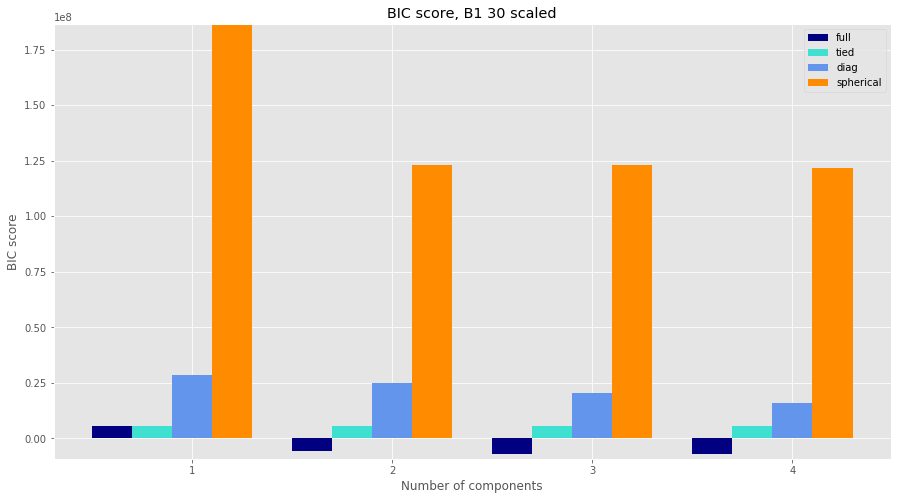

Fitting models for cv_type 'tied'
Done with components: 1 2 3 4 
Fitting models for cv_type 'diag'
Done with components: 1 2 3 4 
Fitting models for cv_type 'spherical'
Done with components: 1 2 3 4 



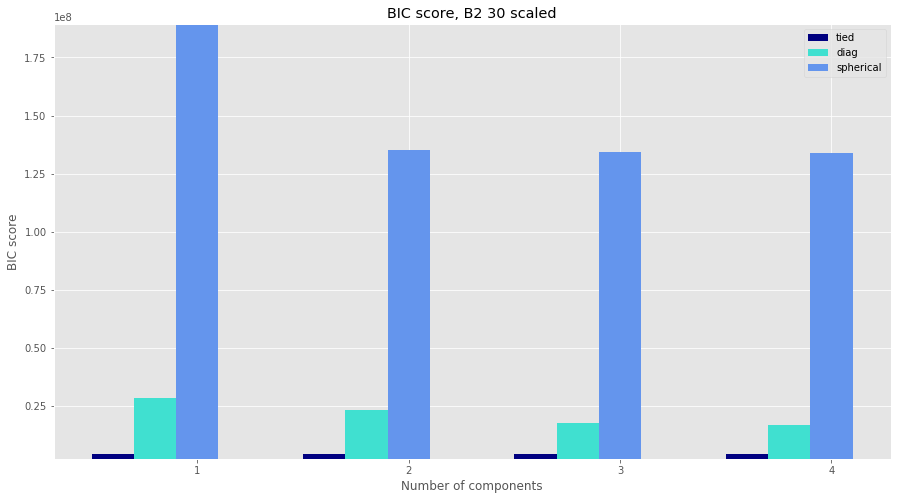

In [6]:
bic1 = GMM.bic_scores(B1_30_s, max_n_components=4)
plot.features.gmm_bic_scores(bic1, max_n_components=4, title="BIC score, B1 30 scaled")

cv_types = ["tied", "diag", "spherical"]
bic2 = GMM.bic_scores(B2_30_s, max_n_components=4, cv_types=cv_types)
plot.features.gmm_bic_scores(bic2, max_n_components=4, cv_types=cv_types, title="BIC score, B2 30 scaled")

In [7]:
clf = GMM.GMM(n_components=5, covariance_type='full')
B1_30_s = clf.fit_and_append_scores(B1_30_s)

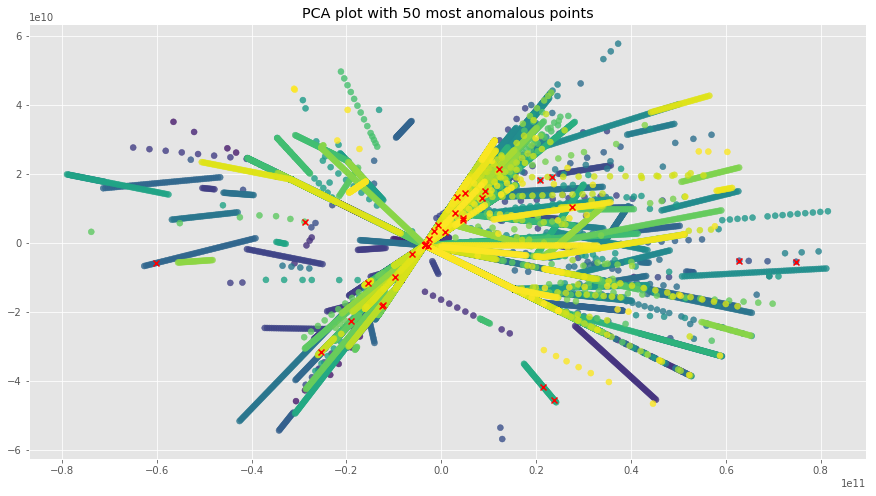

In [8]:
top50_ts = clf.n_most_anomalous_timestamps(B1_30_s, 50)
top50_idx = clf.n_most_anomalous_idx(B1_30_s, 50)

p = PCA.PCA(n_components=2)
p_data = p.transform(B1_30_s)
plot.anomalies.pca_anomalies(p_data, top50_idx, "PCA plot with 50 most anomalous points")

## Evaluation (Beam 1)

In [9]:
labels = db.query_elogbook_anomalies()
predictions = B1_30_s.loc[top50_ts]

predictions_w_label, labels_w_prediction = evaluation.labels_vs_predictions(labels, predictions)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


In [10]:
predictions_w_label.head()

has_label
2016-04-21 16:38:41      False
2016-04-26 03:08:23      False
2016-05-09 18:50:38      False
2016-05-30 05:47:52       True
2016-06-02 03:49:50      False

In [11]:
labels_w_prediction.head()

points
2016-05-30 14:00:00       1
2016-06-05 17:18:00       0
2016-06-18 19:59:00       0
2016-06-19 13:14:00       2
2016-06-30 21:23:00       1

In [12]:
predictions_with_label_ratio = float(predictions_w_label.sum() / predictions_w_label.count())
"Ratio detected with label: {0}".format(predictions_with_label_ratio)

'Ratio detected with label: 0.18'

Only 24% of all predictions lie close to a label. This is partially due to the detected timestamps on the 2nd of August: half of them are after the entry in the logbook.

In [13]:
labels_w_prediction_ratio = float(labels_w_prediction.astype(bool).sum() / labels_w_prediction.count())
"Ratio labeled with count: {0}".format(labels_w_prediction_ratio)

'Ratio labeled with count: 0.375'

Most labeled anomalies have no corresponding detected timestamps. Of all labeled anomalies, 31% have a corresponding timestamp.

### Clustering
Detected points can be clustered by using `create_segments`. The distance from a detected point to a cluster should be no more than 12 hours. The distance can be calculated with 4 methods:

* "start": distance to earliest timestamp in cluster
* "end": distance to latest timestamp in cluster
* "mean": distance to mean timestamp in cluster
* "edge": min distance to max or min timestamp in cluster

In [14]:
anomalous_segments = segmentation.create_segments(predictions, method="mean")

display("Number of clusters: {0}".format(len(anomalous_segments)))
display("Average cluster length: {0}".format(np.mean([segment.length() for segment in anomalous_segments])))
for segment in anomalous_segments:
    display(segment.format_ts())

'Number of clusters: 32'

'Average cluster length: 0 days 00:45:30.156250'

['2016-08-02 17:28.14',
 '2016-08-02 17:28.54',
 '2016-08-02 18:55.01',
 '2016-08-02 18:57.31',
 '2016-08-02 19:00.51',
 '2016-08-02 19:04.11',
 '2016-08-02 19:06.41',
 '2016-08-02 22:52.20',
 '2016-08-03 04:58.00']

['2016-07-09 14:39.25']

['2016-07-30 22:26.58', '2016-07-31 01:25.47', '2016-07-31 01:26.37']

['2016-07-25 11:57.58',
 '2016-07-25 15:38.13',
 '2016-07-25 15:39.20',
 '2016-07-25 15:59.29']

['2016-06-19 12:50.40', '2016-06-19 12:51.00']

['2016-07-11 16:49.53']

['2016-08-07 06:18.25']

['2016-06-30 20:32.13']

['2016-07-29 10:01.55', '2016-07-29 10:03.16']

['2016-08-31 06:58.46', '2016-08-31 12:27.57']

['2016-06-24 07:00.47']

['2016-07-12 19:59.19']

['2016-09-06 12:40.52']

['2016-06-02 03:49.50']

['2016-04-21 16:38.41']

['2016-09-02 02:44.37']

['2016-08-13 12:55.40']

['2016-05-30 05:47.52']

['2016-06-30 02:51.27']

['2016-08-17 06:18.50']

['2016-07-28 12:04.35', '2016-07-28 12:14.47']

['2016-06-14 14:29.16', '2016-06-14 14:33.21']

['2016-07-22 08:01.26']

['2016-08-04 13:43.39']

['2016-08-29 18:17.25']

['2016-07-10 06:42.57']

['2016-04-26 03:08.23']

['2016-06-26 12:32.31']

['2016-09-10 07:11.23']

['2016-05-09 18:50.38']

['2016-08-25 19:55.01']

['2016-09-09 06:13.57']

In [15]:
labels_w_segments = evaluation.labels_vs_segments(labels, anomalous_segments, method="start")
labels_w_segments

segments  points        score
2016-05-30 14:00:00         1       1  -124.201479
2016-06-05 17:18:00         0       0     0.000000
2016-06-18 19:59:00         0       0     0.000000
2016-06-19 13:14:00         1       2  -295.370289
2016-06-30 21:23:00         1       1  -148.768575
2016-07-14 09:23:00         0       0     0.000000
2016-07-24 22:19:48         0       0     0.000000
2016-07-31 16:00:00         0       0     0.000000
2016-08-02 17:28:00         0       0     0.000000
2016-08-02 17:50:00         1       9 -1828.802616
2016-08-03 08:05:00         0       0     0.000000
2016-08-04 14:03:41         1       1  -120.438969
2016-08-21 20:00:00         0       0     0.000000
2016-08-22 21:30:30         0       0     0.000000
2016-08-23 06:53:47         0       0     0.000000
2016-09-02 17:43:00         0       0     0.000000

### Beam 1 and 2
50 points leads to 15 clusters which is not a lot. The numer of points has to be increased.

In [16]:
clf_B1 = GMM.GMM(n_components=5, covariance_type='tied')
B1_scored = clf_B1.fit_and_append_scores(B1_30_s)
B1_predictions = clf_B1.n_most_anomalous_points(B1_scored, 1000)

clf_B2 = GMM.GMM(n_components=5, covariance_type='tied')
B2_scored = clf_B2.fit_and_append_scores(B2_30_s)
B2_predictions = clf_B2.n_most_anomalous_points(B2_scored, 1000)

On getting indices of most anomalous points:
Use method that returns timestamps, this will then stay correct even if the dataframe is sorted differently later on.

In [17]:
# based on index numbers
method_one = B1_scored.iloc[B1_scored['score'].values.argsort()[:1000]]
# based on timestamps
method_two = B1_scored.loc[B1_scored.sort_values(by='score')[:1000].index]

display(
    method_one.equals(method_two),
    clf_B1.n_most_anomalous_timestamps(B1_scored, 5),
    clf_B1.n_most_anomalous_points(B1_scored, 5)
)

True

DatetimeIndex(['2016-04-21 16:38:41', '2016-07-11 16:49:53',
               '2016-07-29 10:01:55', '2016-08-03 04:58:00',
               '2016-08-07 06:18:25'],
              dtype='datetime64[ns]', freq=None)

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
2016-04-21 16:38:41                   57.273635                   56.629024   
2016-07-11 16:49:53                   53.221433                   53.277390   
2016-07-29 10:01:55                   -0.191549                   51.272731   
2016-08-03 04:58:00                    0.621667                    0.620872   
2016-08-07 06:18:25                   56.576068                   50.980492   

                     MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
2016-04-21 16:38:41                 -0.515076                 -0.515126   
2016-07-11 16:49:53                 -0.515076                 -0.515126   
2016-07-29 10:01:55                 -0.515076                 -0.515126   
2016-08-03 04:58:00                  0.710525                  0.710531   
2016-08-07 06:18:25                 -0.515096                 -0.515126   

                     MKI.UA23.IPOC.AB1:T_FALLTIME  \
2016-04-21 16:38:41                   -132.733333   
2016-07-11 16:49:53                 -11234.276190   
2016-07-29 10:01:55                   -132.638095   
2016-08-03 04:58:00                     -0.742857   
2016-08-07 06:18:25                   -127.790476   

                     MKI.UA23.IPOC.DB1:T_FALLTIME  \
2016-04-21 16:38:41                 -11854.576923   
2016-07-11 16:49:53                   -137.615385   
2016-07-29 10:01:55                   -135.269231   
2016-08-03 04:58:00                    -62.028846   
2016-08-07 06:18:25                   -131.807692   

                     MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
2016-04-21 16:38:41                      -13190.8                 -0.515126   
2016-07-11 16:49:53                      -10457.6                 -0.515126   
2016-07-29 10:01:55                      -10457.6                 -0.515126   
2016-08-03 04:58:00                           0.2                  0.710531   
2016-08-07 06:18:25                      -13195.0                 -0.515126   

                     MKI.UA23.IPOC.CB1:I_STRENGTH  \
2016-04-21 16:38:41                      0.041996   
2016-07-11 16:49:53                      0.651759   
2016-07-29 10:01:55                     -0.042542   
2016-08-03 04:58:00                      0.553586   
2016-08-07 06:18:25                      0.658849   

                     MKI.UA23.IPOC.BB1:T_RISETIME      ...       \
2016-04-21 16:38:41                   -129.450980      ...        
2016-07-11 16:49:53                   -129.352941      ...        
2016-07-29 10:01:55                   -129.450980      ...        
2016-08-03 04:58:00                      0.764706      ...        
2016-08-07 06:18:25                   -129.411765      ...        

                     MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
2016-04-21 16:38:41                               -0.434870   
2016-07-11 16:49:53                                0.179137   
2016-07-29 10:01:55                               -0.390966   
2016-08-03 04:58:00                               -0.267254   
2016-08-07 06:18:25                                0.634924   

                     MKI.D5L2.B1:TEMP_TUBE_DOWN:SW_SUM_1800_s  \
2016-04-21 16:38:41                                 -0.533560   
2016-07-11 16:49:53                                  0.126552   
2016-07-29 10:01:55                                 -0.439574   
2016-08-03 04:58:00                                 -0.309439   
2016-08-07 06:18:25                                  0.583822   

                     MKI.C5L2.B1:TEMP_MAGNET_UP:SW_SUM_1800_s  \
2016-04-21 16:38:41                                 -0.745907   
2016-07-11 16:49:53                                  0.658516   
2016-07-29 10:01:55                                 -0.565949   
2016-08-03 04:58:00                                 -0.206034   
2016-08-07 06:18:25                                  0.238567   

                     MKI.C5L2.B1:TEMP_MAGNET_DOWN:SW_SUM_1800_s  \
2016-04-21 16:38:41             

In [18]:
B1_segments = segmentation.create_segments(B1_predictions, method="mean")
B2_segments = segmentation.create_segments(B2_predictions, method="mean")

segmentation.print_segment_stats(B1_segments, B2_segments)

B1: Number of segments:  114
B1: Min segment length:  0 days 00:00:00
B1: Mean segment length: 0 days 04:28:45.315789
B1: Max segment length:  0 days 17:17:37
B1: Check: anomalies:    1000

B2: Number of segments:  123
B2: Min segment length:  0 days 00:00:00
B2: Mean segment length: 0 days 05:16:57.105691
B2: Max segment length:  0 days 18:46:03
B1: Check: anomalies:    1000


In [19]:
evaluation.labels_vs_segments_beams(labels, B1_segments, B2_segments)

beam       B1                            B2         \
                         segments points         score segments points   
2016-05-30 14:00:00    2      1.0    5.0  -2831.914619      1.0    3.0   
2016-06-05 17:18:00    2      1.0    3.0  -1229.566483      1.0    4.0   
2016-06-18 19:59:00    2      1.0    1.0   -919.677802      1.0    9.0   
2016-06-19 13:14:00    1      1.0   46.0 -13091.755089      1.0    3.0   
2016-06-30 21:23:00    1      1.0  129.0 -20573.392657      1.0  109.0   
2016-07-14 09:23:00    2      0.0    0.0      0.000000      0.0    0.0   
2016-07-24 22:19:48    1      1.0    1.0  -1060.701428      1.0   21.0   
2016-07-31 16:00:00    1      1.0    3.0  -2148.877624      1.0    4.0   
2016-08-02 17:28:00    1      1.0   62.0 -39595.748423      1.0    1.0   
2016-08-02 17:50:00    1      1.0   62.0 -39595.748423      1.0    1.0   
2016-08-03 08:05:00    1      0.0    0.0      0.000000      0.0    0.0   
2016-08-04 14:03:41    1      1.0    5.0  -2476.969550      1.0    5.0   
2016-08-21 20:00:00    2      1.0    3.0  -1169.155539      1.0   71.0   
2016-08-22 21:30:30    2      1.0    4.0  -4962.715066      1.0    4.0   
2016-08-23 06:53:47    1      0.0    0.0      0.000000      0.0    0.0   
2016-09-02 17:43:00    2      0.0    0.0      0.000000      0.0    0.0   

                                   
                            score  
2016-05-30 14:00:00   -786.489338  
2016-06-05 17:18:00  -2697.569475  
2016-06-18 19:59:00  -9671.581043  
2016-06-19 13:14:00   -322.999742  
2016-06-30 21:23:00 -13196.722523  
2016-07-14 09:23:00      0.000000  
2016-07-24 22:19:48  -6869.337694  
2016-07-31 16:00:00  -4082.395295  
2016-08-02 17:28:00    -87.984094  
2016-08-02 17:50:00    -87.984094  
2016-08-03 08:05:00      0.000000  
2016-08-04 14:03:41  -5175.748236  
2016-08-21 20:00:00 -20784.645230  
2016-08-22 21:30:30  -2894.145863  
2016-08-23 06:53:47      0.000000  
2016-09-02 17:43:00      0.000000

Model doesn't detect most points in the labeled set.

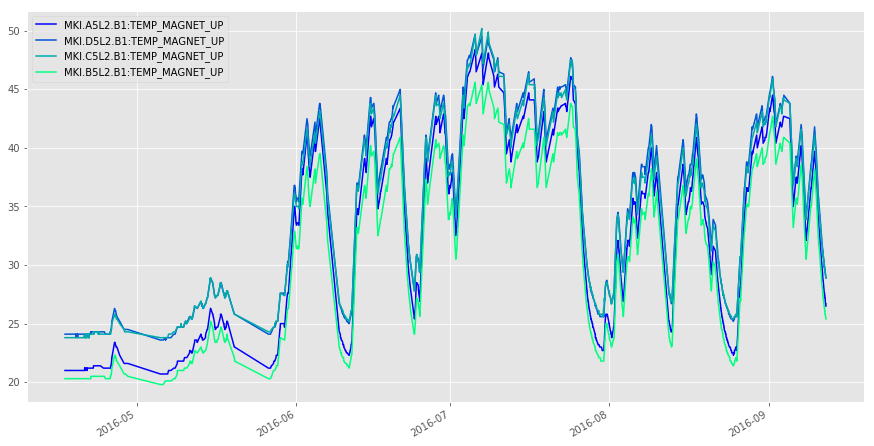

In [20]:
_, axes = plt.subplots()
timeseries = B1_30.filter(regex='^MKI.*:TEMP_MAGNET_UP$')
timeseries.plot(ax=axes, colormap='winter', kind='line')

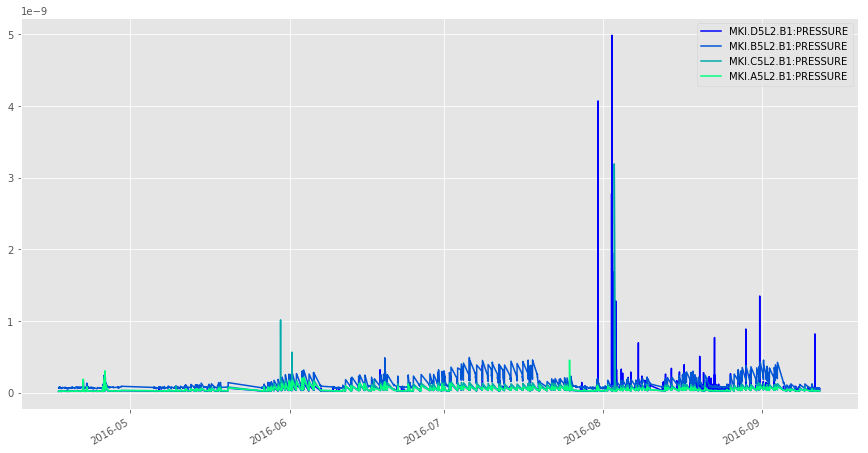

In [21]:
_, axes = plt.subplots()
timeseries = B1_30.filter(regex='^MKI.*:PRESSURE$')
timeseries.plot(ax=axes, colormap='winter', kind='line')

Adjust filters for pressure?